<a href="https://colab.research.google.com/github/Swastik200/Nykaa/blob/main/BILSTPSO1_FD001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp "/content/drive/MyDrive/CMAPSSData.zip" "/content"
!unzip CMAPSSData.zip

Archive:  CMAPSSData.zip
replace CMAPSS/RUL_FD001.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace CMAPSS/RUL_FD002.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace CMAPSS/RUL_FD003.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace CMAPSS/RUL_FD004.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace CMAPSS/test_FD001.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace CMAPSS/test_FD002.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace CMAPSS/test_FD003.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace CMAPSS/test_FD004.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace CMAPSS/train_FD001.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace CMAPSS/train_FD002.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace CMAPSS/train_FD003.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace CMAPSS/train_FD004.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace CMAPSS/x.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
import numpy as np
import pandas as pd
import os

In [5]:
dataPath = '/content/CMAPSS/'

In [6]:
setNumber = 1

In [7]:
id_col = ['id']
cycle_col = ['cycle']
setting_cols = ['setting1', 'setting2', 'setting3']
sensor_cols = ['sensor' + str(i) for i in range(1, 22)]
rul_col = ['RUL']
all_cols = id_col + cycle_col + setting_cols + sensor_cols + rul_col

In [8]:
# This section is to load data
def loadData(fileName):
    data = pd.read_csv(fileName, sep=" ", header=None)
    data.drop([26, 27], axis = 1, inplace=True)
    data.columns = id_col + cycle_col + setting_cols +sensor_cols
    return data

In [9]:
# load train RUL also returns the max cycle, and this max cycle is also the life cylce
def addTrainRul(data, decrease_threshold=None):
    lifeCycles = {mcId: data[data['id']==mcId]['cycle'].max() for mcId in data['id'].unique()}
    if decrease_threshold == None: decrease_threshold = 1
    ruls = [lifeCycles[row[0]] - decrease_threshold if row[1] < decrease_threshold else lifeCycles[row[0]] - row[1] for row in data.values]
    data['RUL'] = ruls
    return lifeCycles

# use this last one only, return the data as well as the max life cycles
def loadTrainData(setNumber, decrease_threshold=None):
    fileName = dataPath + '/train_FD00' + str(setNumber) + '.txt'
    data = loadData(fileName)
    lifeCycles = addTrainRul(data, decrease_threshold)
    return data, lifeCycles

In [10]:
decrease_threshold = None
train, trainLifeCycles = loadTrainData(setNumber, decrease_threshold)

In [11]:
def loadTestRul(fileName):
    data = pd.read_csv(fileName, sep = " ", header=None)
    data.drop([1], axis=1, inplace=True)
    data.columns = ['RUL']
    return data
def addTestRul(data, rulData, decrease_threshold=None):
    testRuls = {i+1: rulData.iloc[i, 0] for i in range(len(rulData))}
    lifeCycles = {mcId: data[data['id']==mcId]['cycle'].max() + testRuls[mcId] for mcId in data['id'].unique()}
    if decrease_threshold == None: decrease_threshold = 1
    ruls = [lifeCycles[row[0]] - decrease_threshold if row[1] < decrease_threshold else lifeCycles[row[0]] - row[1] for row in data.values]
    data['RUL'] = ruls
    return lifeCycles
# Use this last one only => return data as well as the max life cycles for each machine
def loadTestData(setNumber, decrease_threshold=None):
    data = loadData(dataPath + '/test_FD00' +str(setNumber)+'.txt')
    rulData = loadTestRul(dataPath + '/RUL_FD00' + str(setNumber)+'.txt')
    lifeCycles = addTestRul(data, rulData, decrease_threshold)
    return data, lifeCycles

In [12]:
# Also make test RUL becomes piecewise
test, testLifeCycles = loadTestData(setNumber, decrease_threshold)

In [13]:
from matplotlib import pyplot as plt
import seaborn as sns

In [14]:
# As of feature selection they often select: 7, 8, 9, 12, 16, 17, 20  (manual selection based on sensor trends)
def plotSensorDataOfId(data, mcId):
    plt.figure(figsize=(30, 20))
    for i in range(21):
        sensor = 'sensor'+str(i+1)
        plt.subplot(10, 3, i+1).set_title(sensor)
        ssdata = data[data['id']==mcId]
        plt.plot(ssdata['cycle'], ssdata[sensor])
    plt.tight_layout()

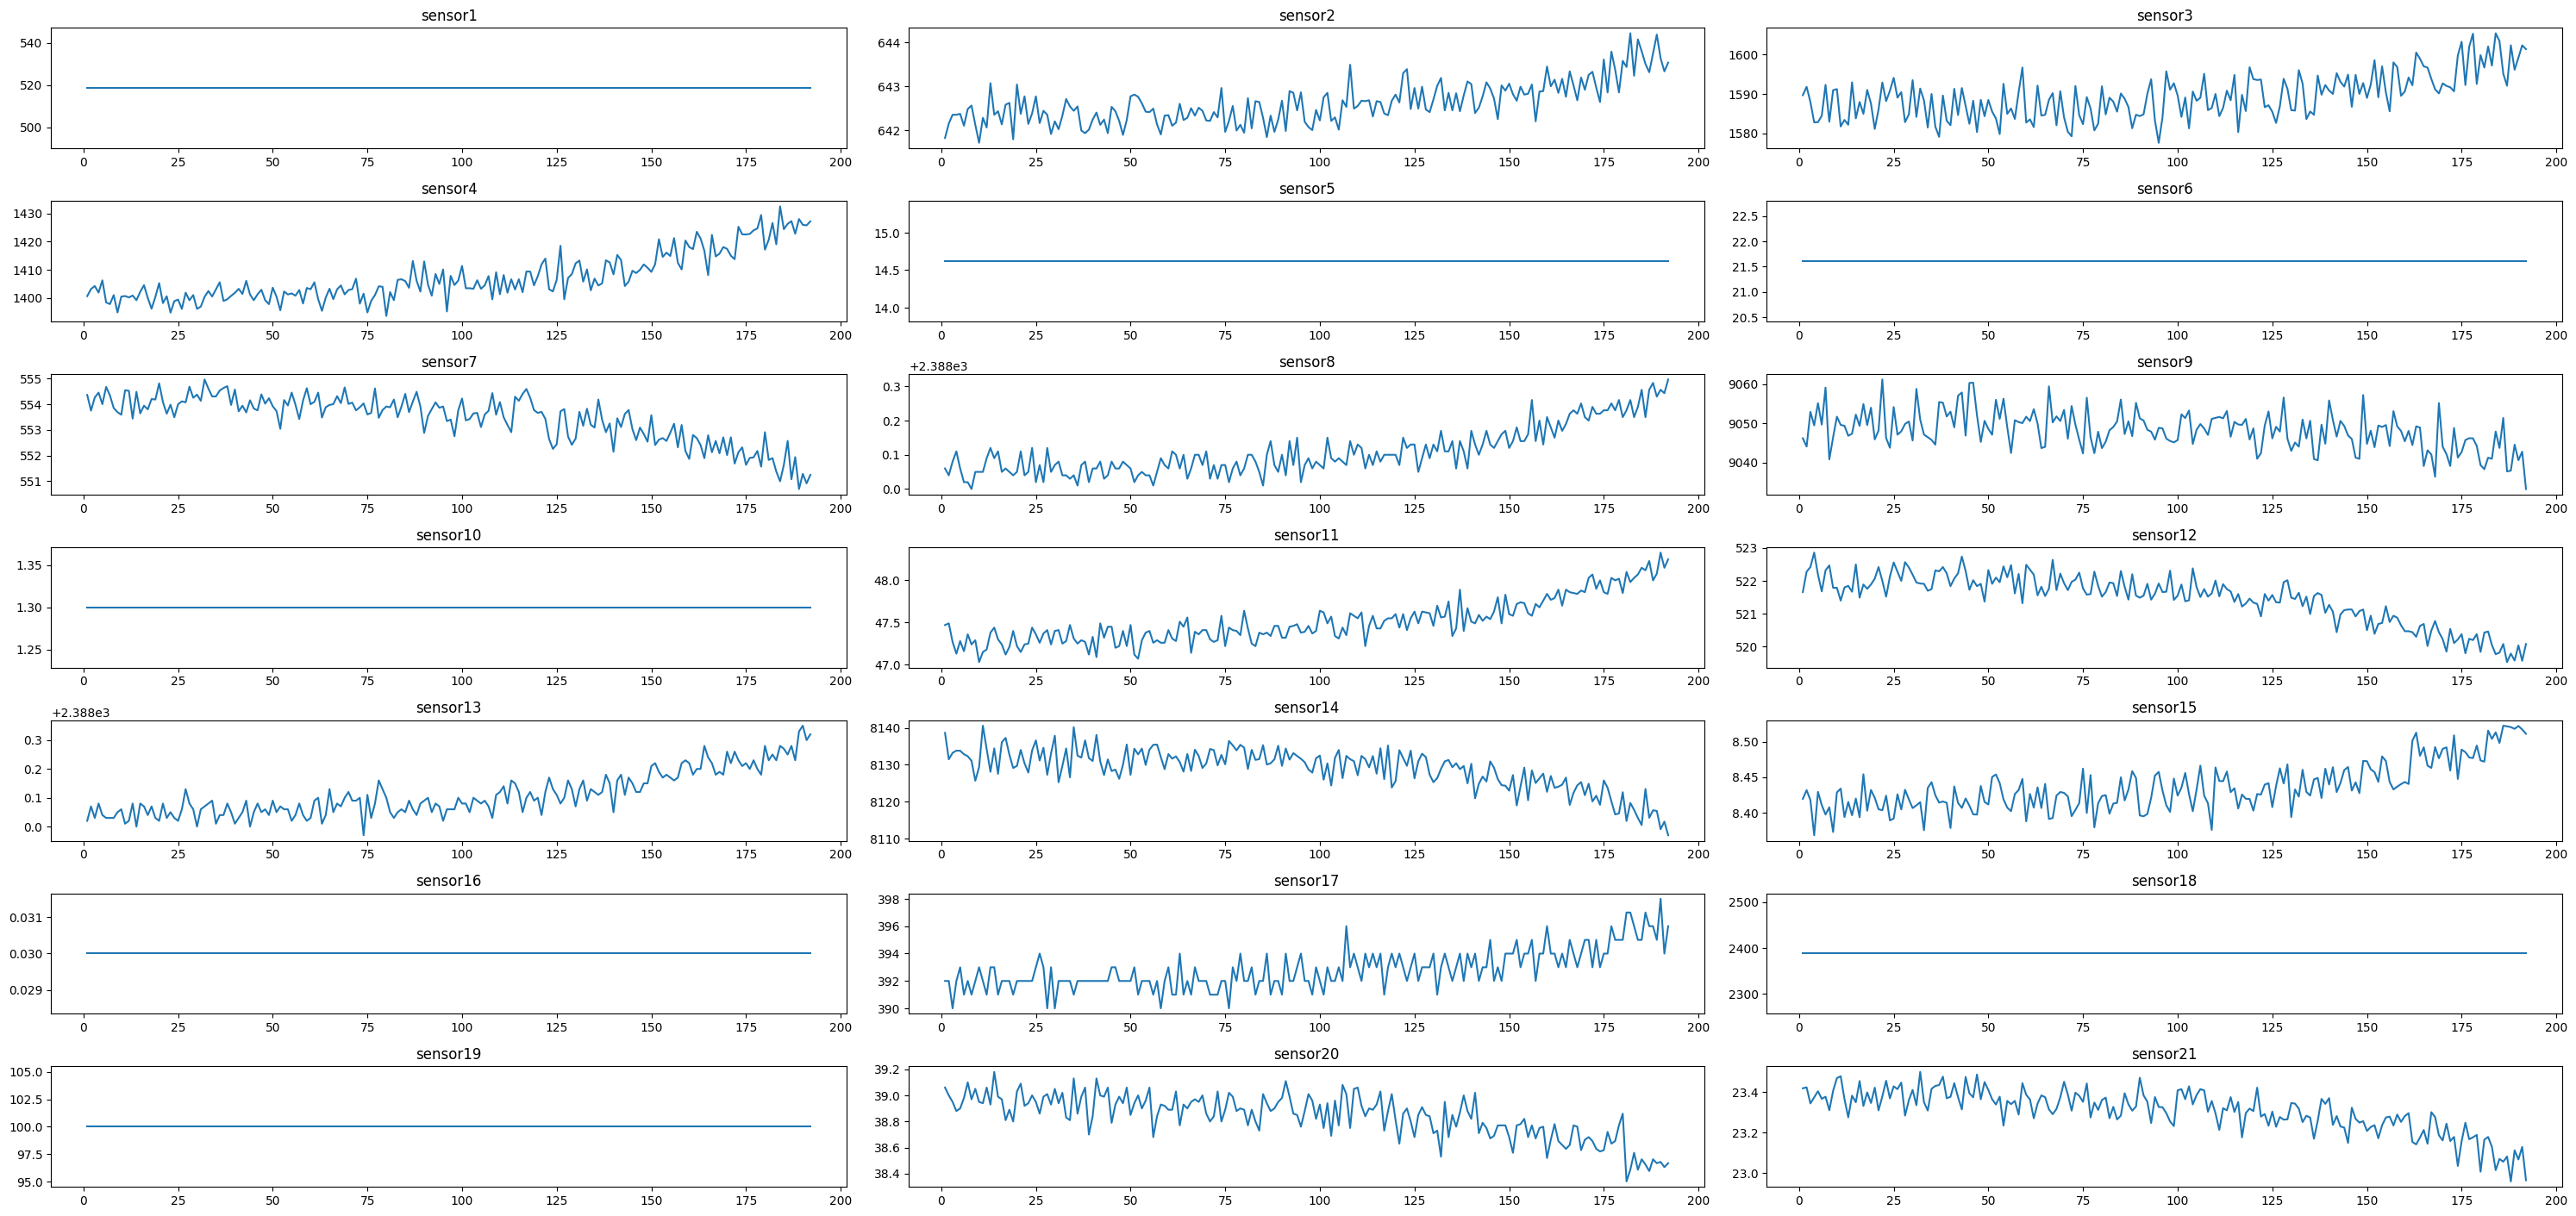

In [14]:
plotSensorDataOfId(train, 1)

In [15]:
def plotDataDistribution(data):
    sensors = []
    plt.figure(figsize=(30, 10))
    for i in range(21):
        sensor = 'sensor'+str(i+1)
        if(len(data[sensor].unique())>1):
            sensors.append(sensor)
            plt.subplot(3, 10, i+1)
            sns.distplot(data[sensor])
    plt.tight_layout()
    return sensors

<ipython-input-15-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[sensor])
<ipython-input-15-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[sensor])
<ipython-input-15-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed 

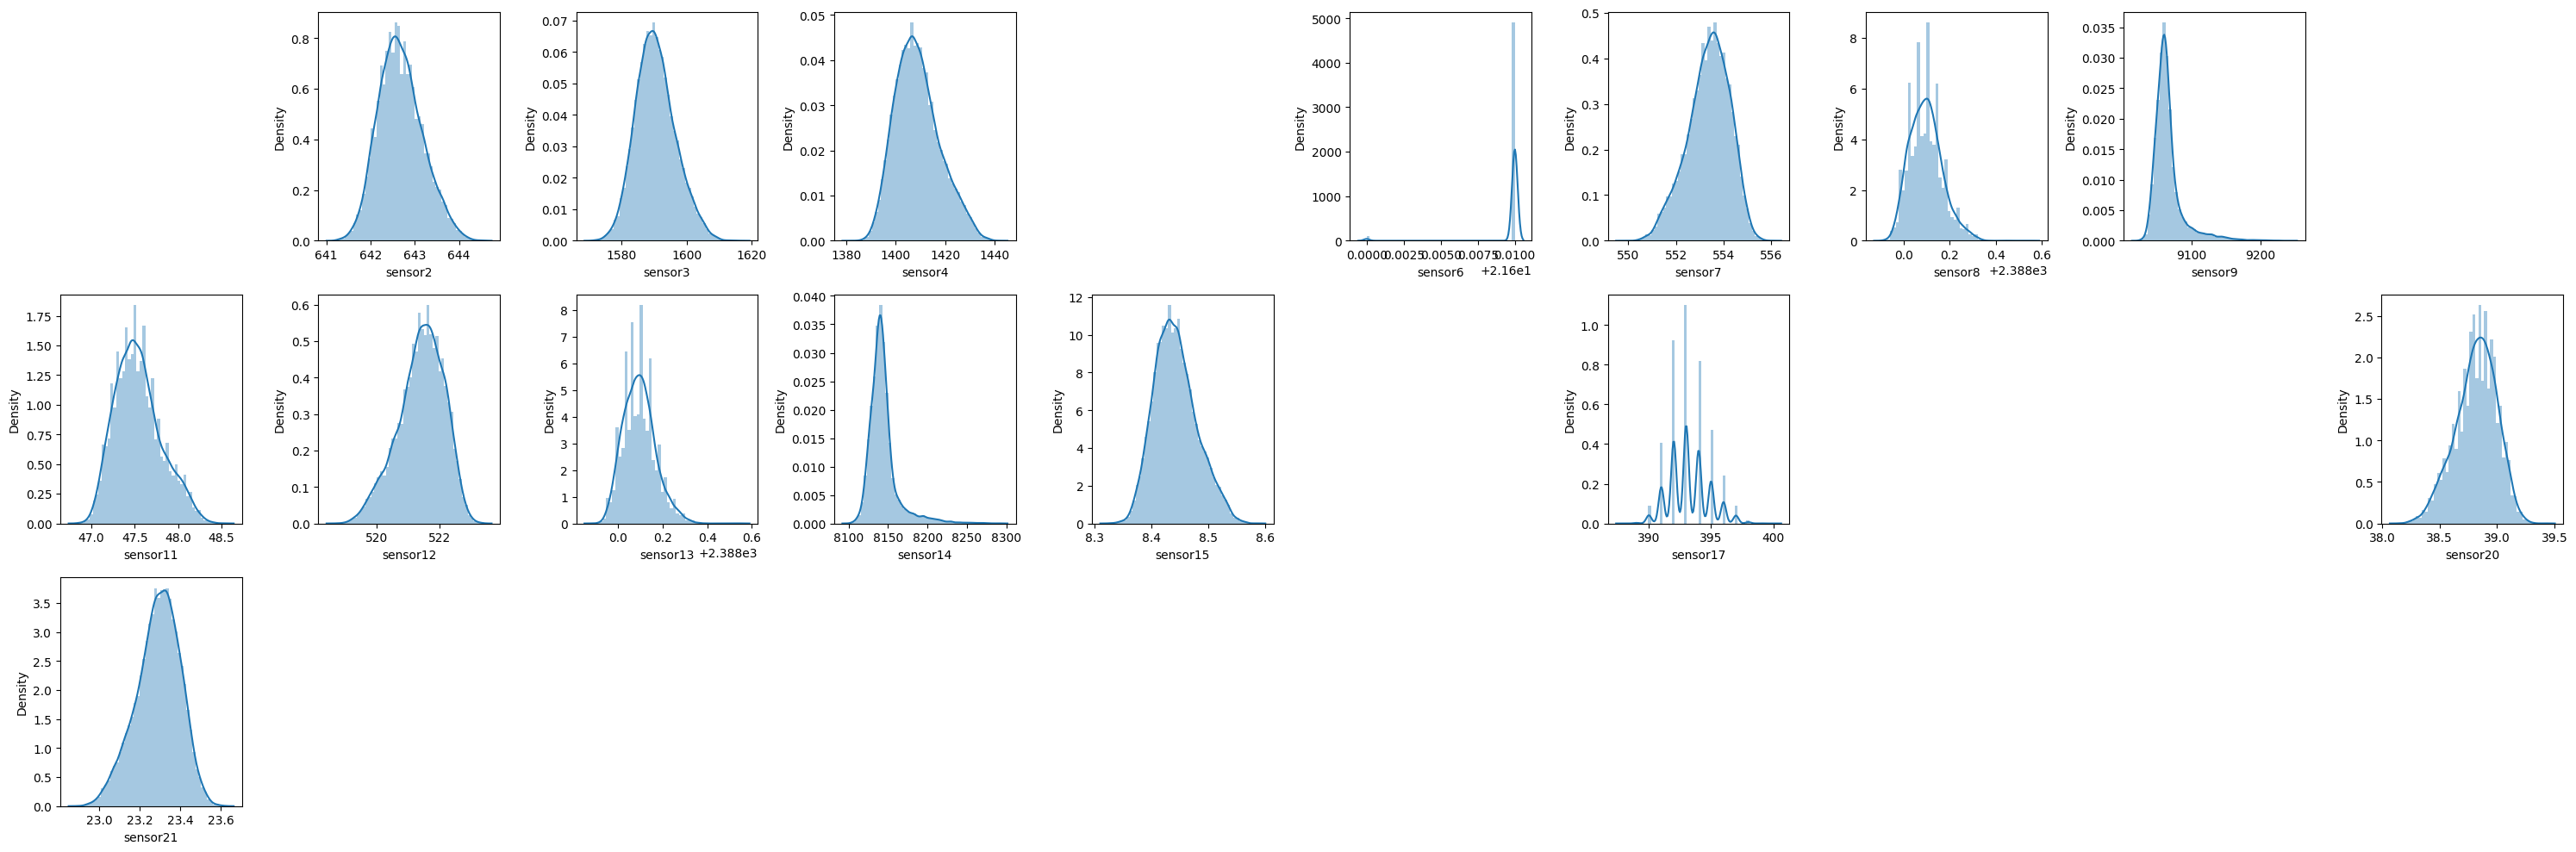

In [16]:
# As of feature selection they often select: 7, 8, 9, 12, 16, 17, 20 => Why 16?
cols = plotDataDistribution(train)

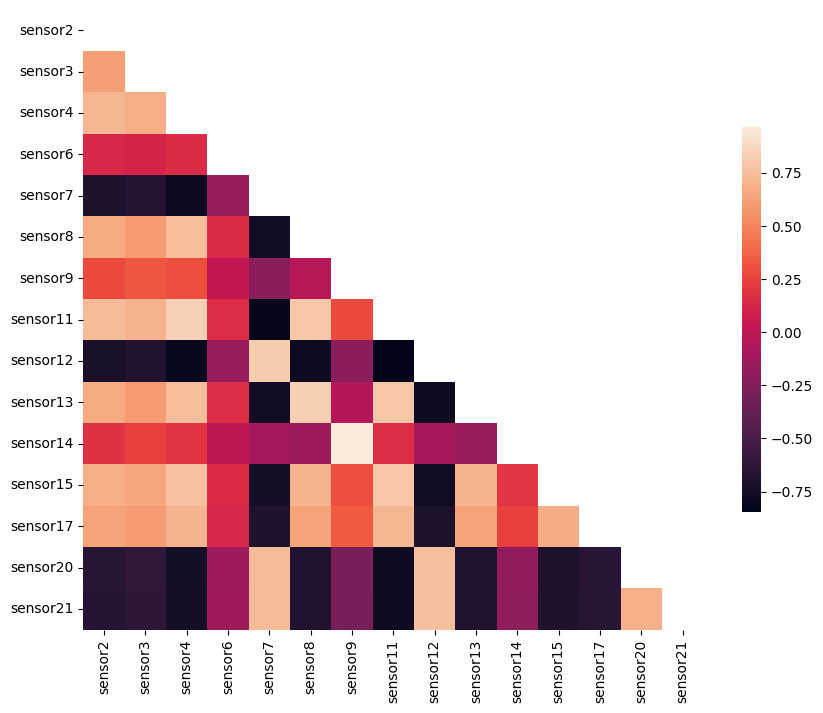

In [17]:
def plotCorrelation(data):
    corr = data.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(10, 10))
    sns.heatmap(data.corr(), square=True, mask=mask, cbar_kws={"shrink": 0.5})

plotCorrelation(train[cols])

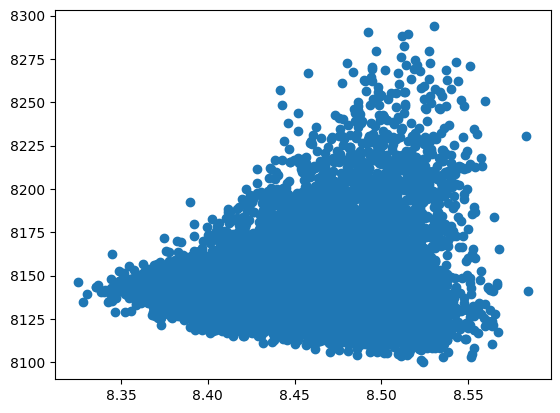

In [18]:
plt.scatter(train['sensor15'].values, train['sensor14'].values)

In [19]:
def plotCorrelationOfID(data, mcId):
    data1 = data[data['id'] == mcId]
    data1 = data1.drop(['id'], axis=1)
    corr = data1.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(10, 10))
    sns.heatmap(data1.corr(), square=True, mask=mask, cbar_kws={"shrink": 0.5})

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
# Scale the data and return the scaled data in form of a df and the scaler (will generate the scaler if doesn't pass it)
def scaleData(data, scaler=None):
    scaled_fields = setting_cols + sensor_cols
    if scaler is None:
        scaler = StandardScaler().fit(data[scaled_fields].values)
    scaled_data = scaler.transform(data[scaled_fields].values)
    scaled_df0 = pd.DataFrame(scaled_data)
    scaled_df0.columns = scaled_fields
    scaled_df1 = data.copy()
    for i in range(len(scaled_fields)):
        theField = scaled_fields[i]
        scaled_df1[theField] = scaled_df0[theField]
    return scaled_df1, scaler

In [22]:
# Scaled train
scaled_train, scaler = scaleData(train)
# Scaled test
scaled_test, scaler = scaleData(test, scaler)

<ipython-input-15-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[sensor])
<ipython-input-15-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[sensor])
<ipython-input-15-ab2dea49aac3>:9: UserWarning: 

`distplot` is a deprecated function and will be removed 

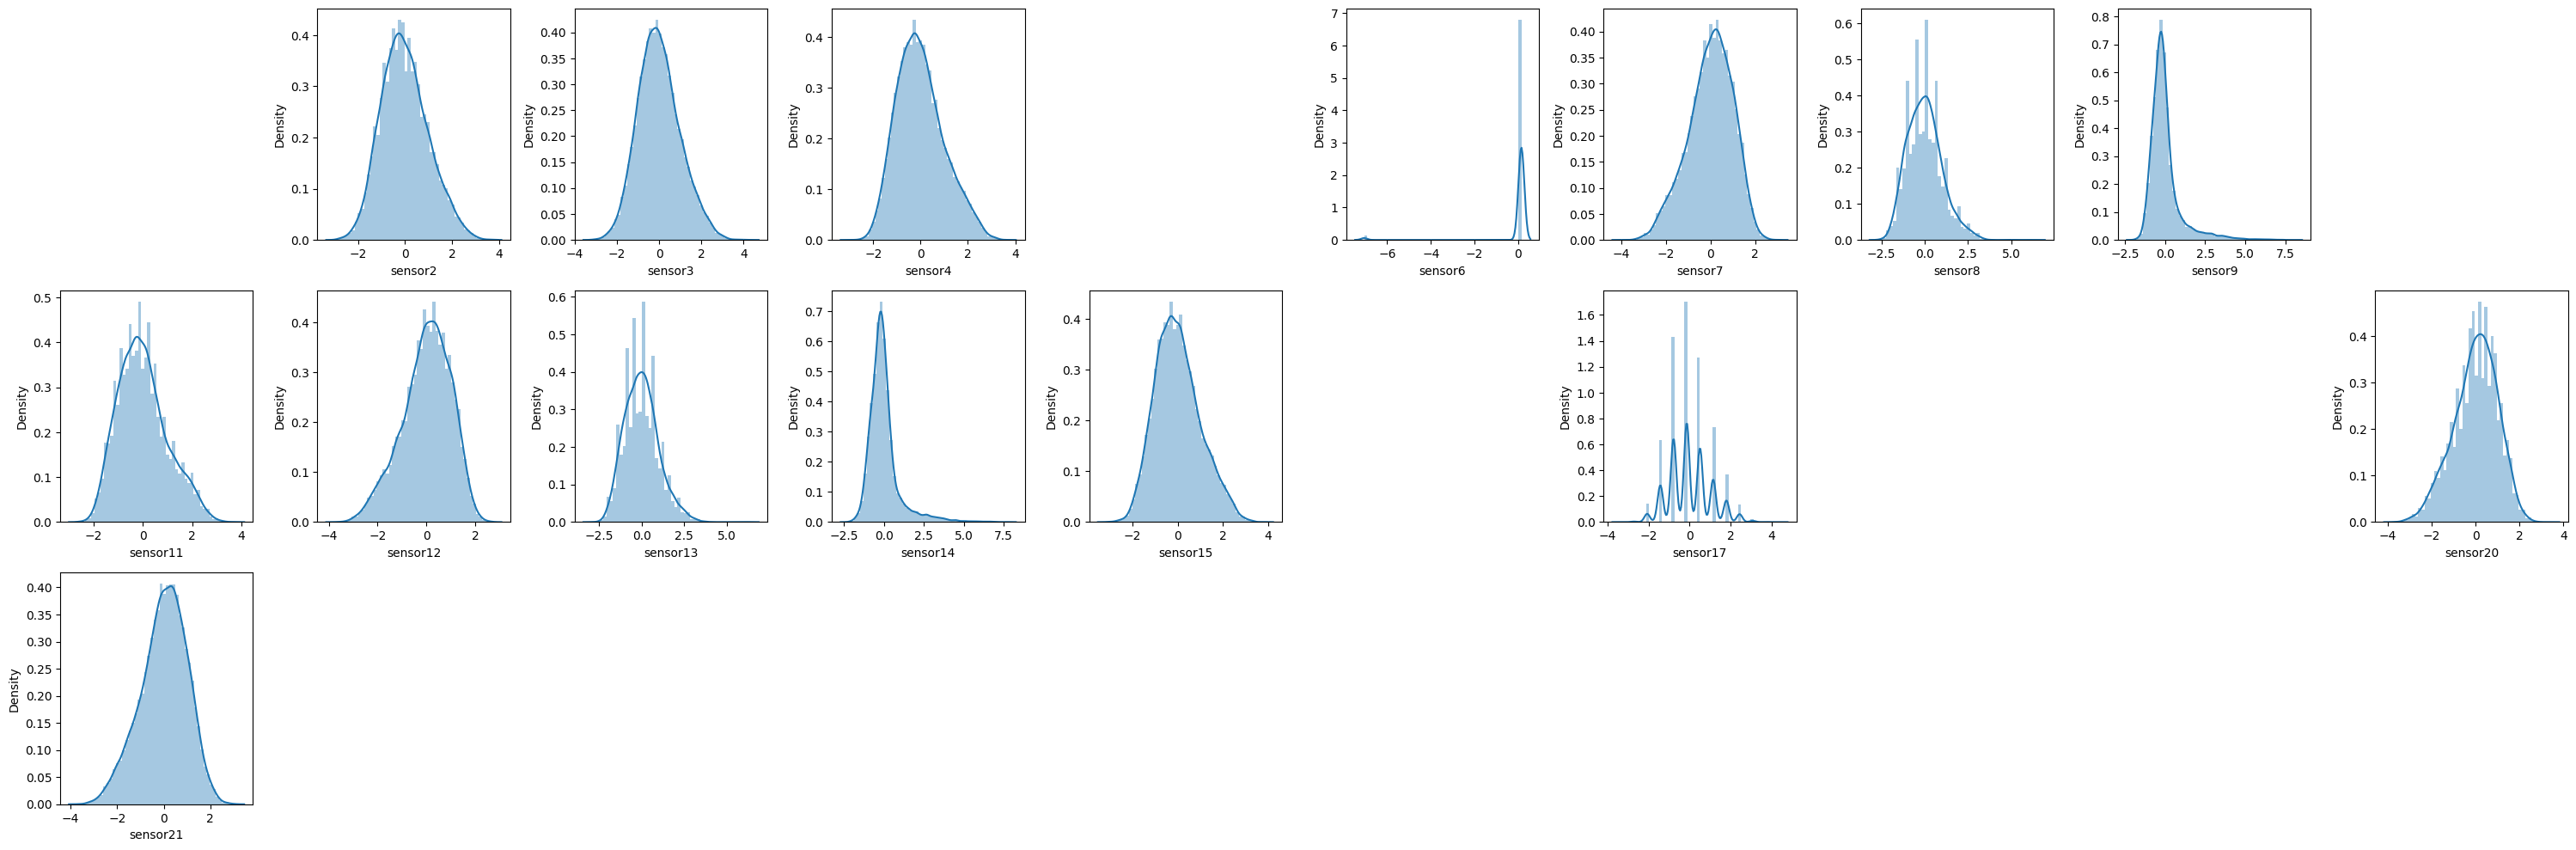

In [23]:
# plot to make sure that the scaled data still keep its shape.
cols = plotDataDistribution(scaled_train)

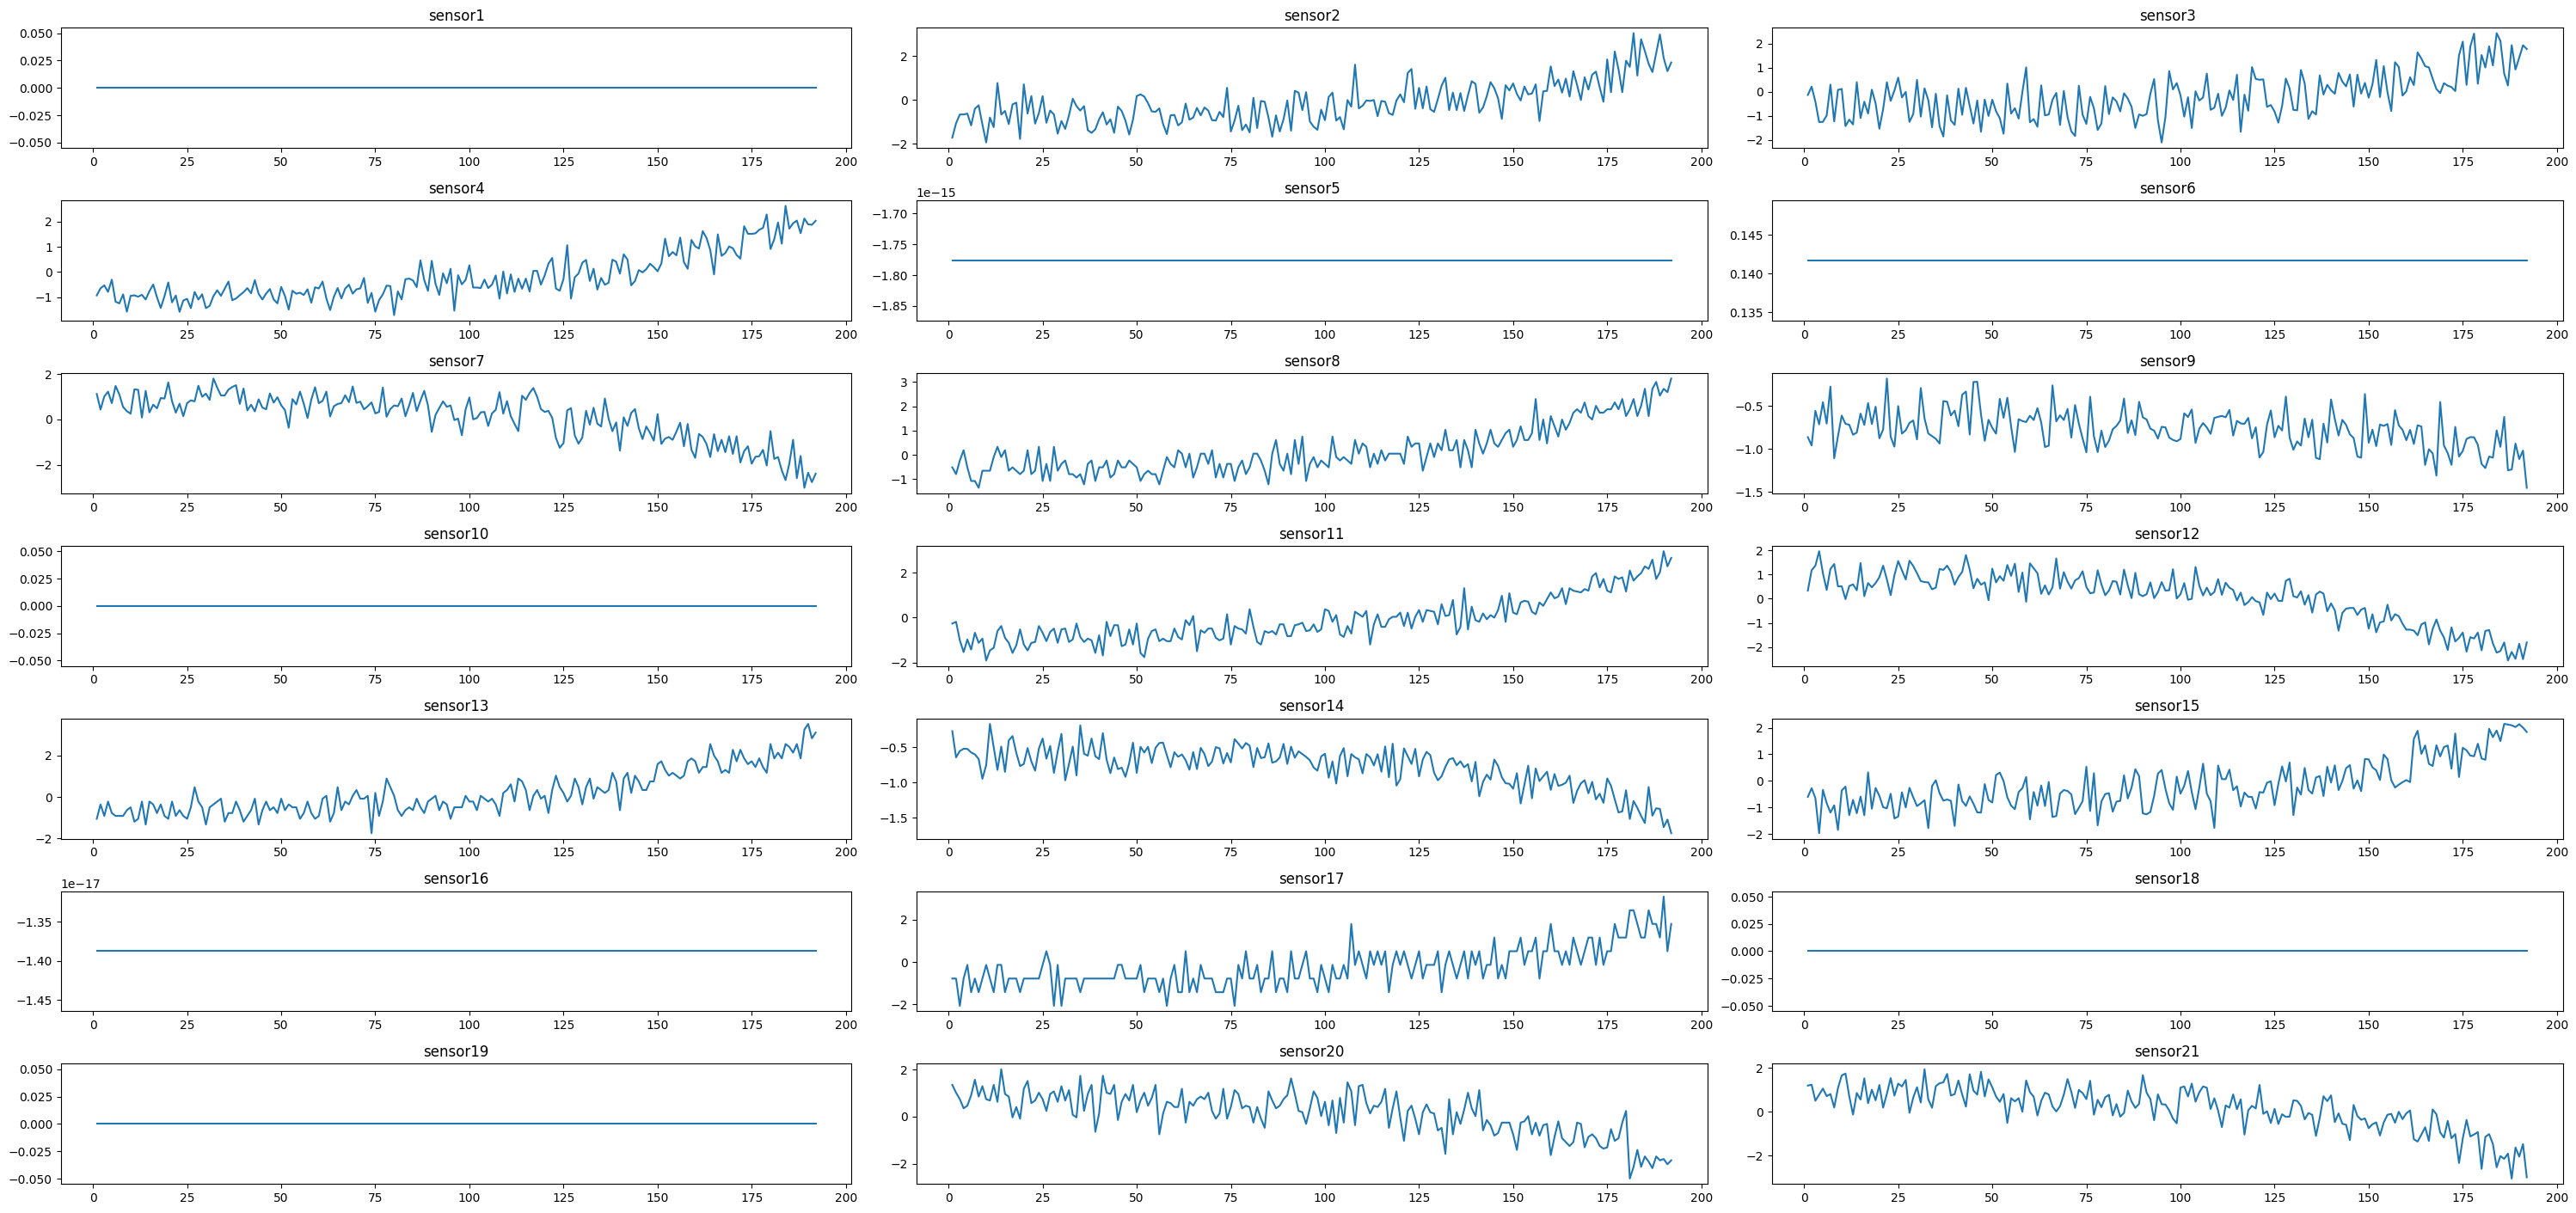

In [24]:
plotSensorDataOfId(scaled_train, 1)

In [25]:
import random
def getPieceWiseData(data, augmentStartCycle=None, augmentEndCycle=None, movingAverage=None):
    uniqueIds = data['id'].unique()
    if movingAverage is None:
        result = [data[data['id'] == mId].values for mId in uniqueIds]
    else:
        result = [data[data['id'] == mId].rolling(movingAverage).mean().dropna().values for mId in uniqueIds]
    maxlen = np.max([len(x) for x in result])
    # Augment the data now
    if augmentStartCycle is not None and augmentEndCycle is not None:
        result1 = []
        for mc in result:
            maxCycle = len(mc)
            for i in range(50):
                idx = random.randint(max([maxCycle - 145, 10]), max([maxCycle - 10, 10]))
                if len(mc[:idx, :]) > 0:
                    result1.append(mc[:idx, :])
        result = result1
    ruls = [min(mc[:, -1]) for mc in result]
    return result, ruls, maxlen

In [27]:
# Use this last one only (prev one is a helper)
from keras.preprocessing.sequence import pad_sequences
def getPaddedSequence(data, pad_type='pre', maxlen=None, augmentStartCycle=None, augmentEndCycle=None, movingAverage=None):
    piece_wise, ruls, ml = getPieceWiseData(data, augmentStartCycle, augmentEndCycle, movingAverage)
    if maxlen is None: maxlen = ml
    padded_sequence = pad_sequences(piece_wise, padding=pad_type, maxlen=maxlen, dtype='float32')
    return padded_sequence, ruls, maxlen

In [29]:
augmentStartCycle = 130
augmentEndCycle = 362
maxlen = 200
movingAverage = None
padded_train, train_ruls, maxlen = getPaddedSequence(scaled_train, maxlen=maxlen, augmentStartCycle=augmentStartCycle, augmentEndCycle=augmentEndCycle, movingAverage=movingAverage)
padded_test, test_ruls, maxlen = getPaddedSequence(scaled_test, maxlen=maxlen, movingAverage=movingAverage)


<Axes: ylabel='Count'>

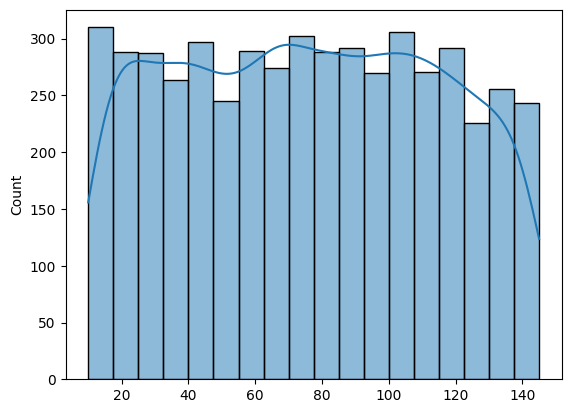

In [30]:
sns.histplot(train_ruls, kde=True)

In [31]:
def plotDataForIndex(data, theIndex):
    plt.figure(figsize=(30, 30))
    for i in range(5, 26):
        plt.subplot(7, 3, i-4)
        values = data[theIndex][:, i]
        plt.plot(range(len(values)) ,values)
        plt.title('sensor'+str(i-4))
        plt.tight_layout()

In [32]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from keras.models import Model
from keras.callbacks import Callback
from keras.optimizers import Adam

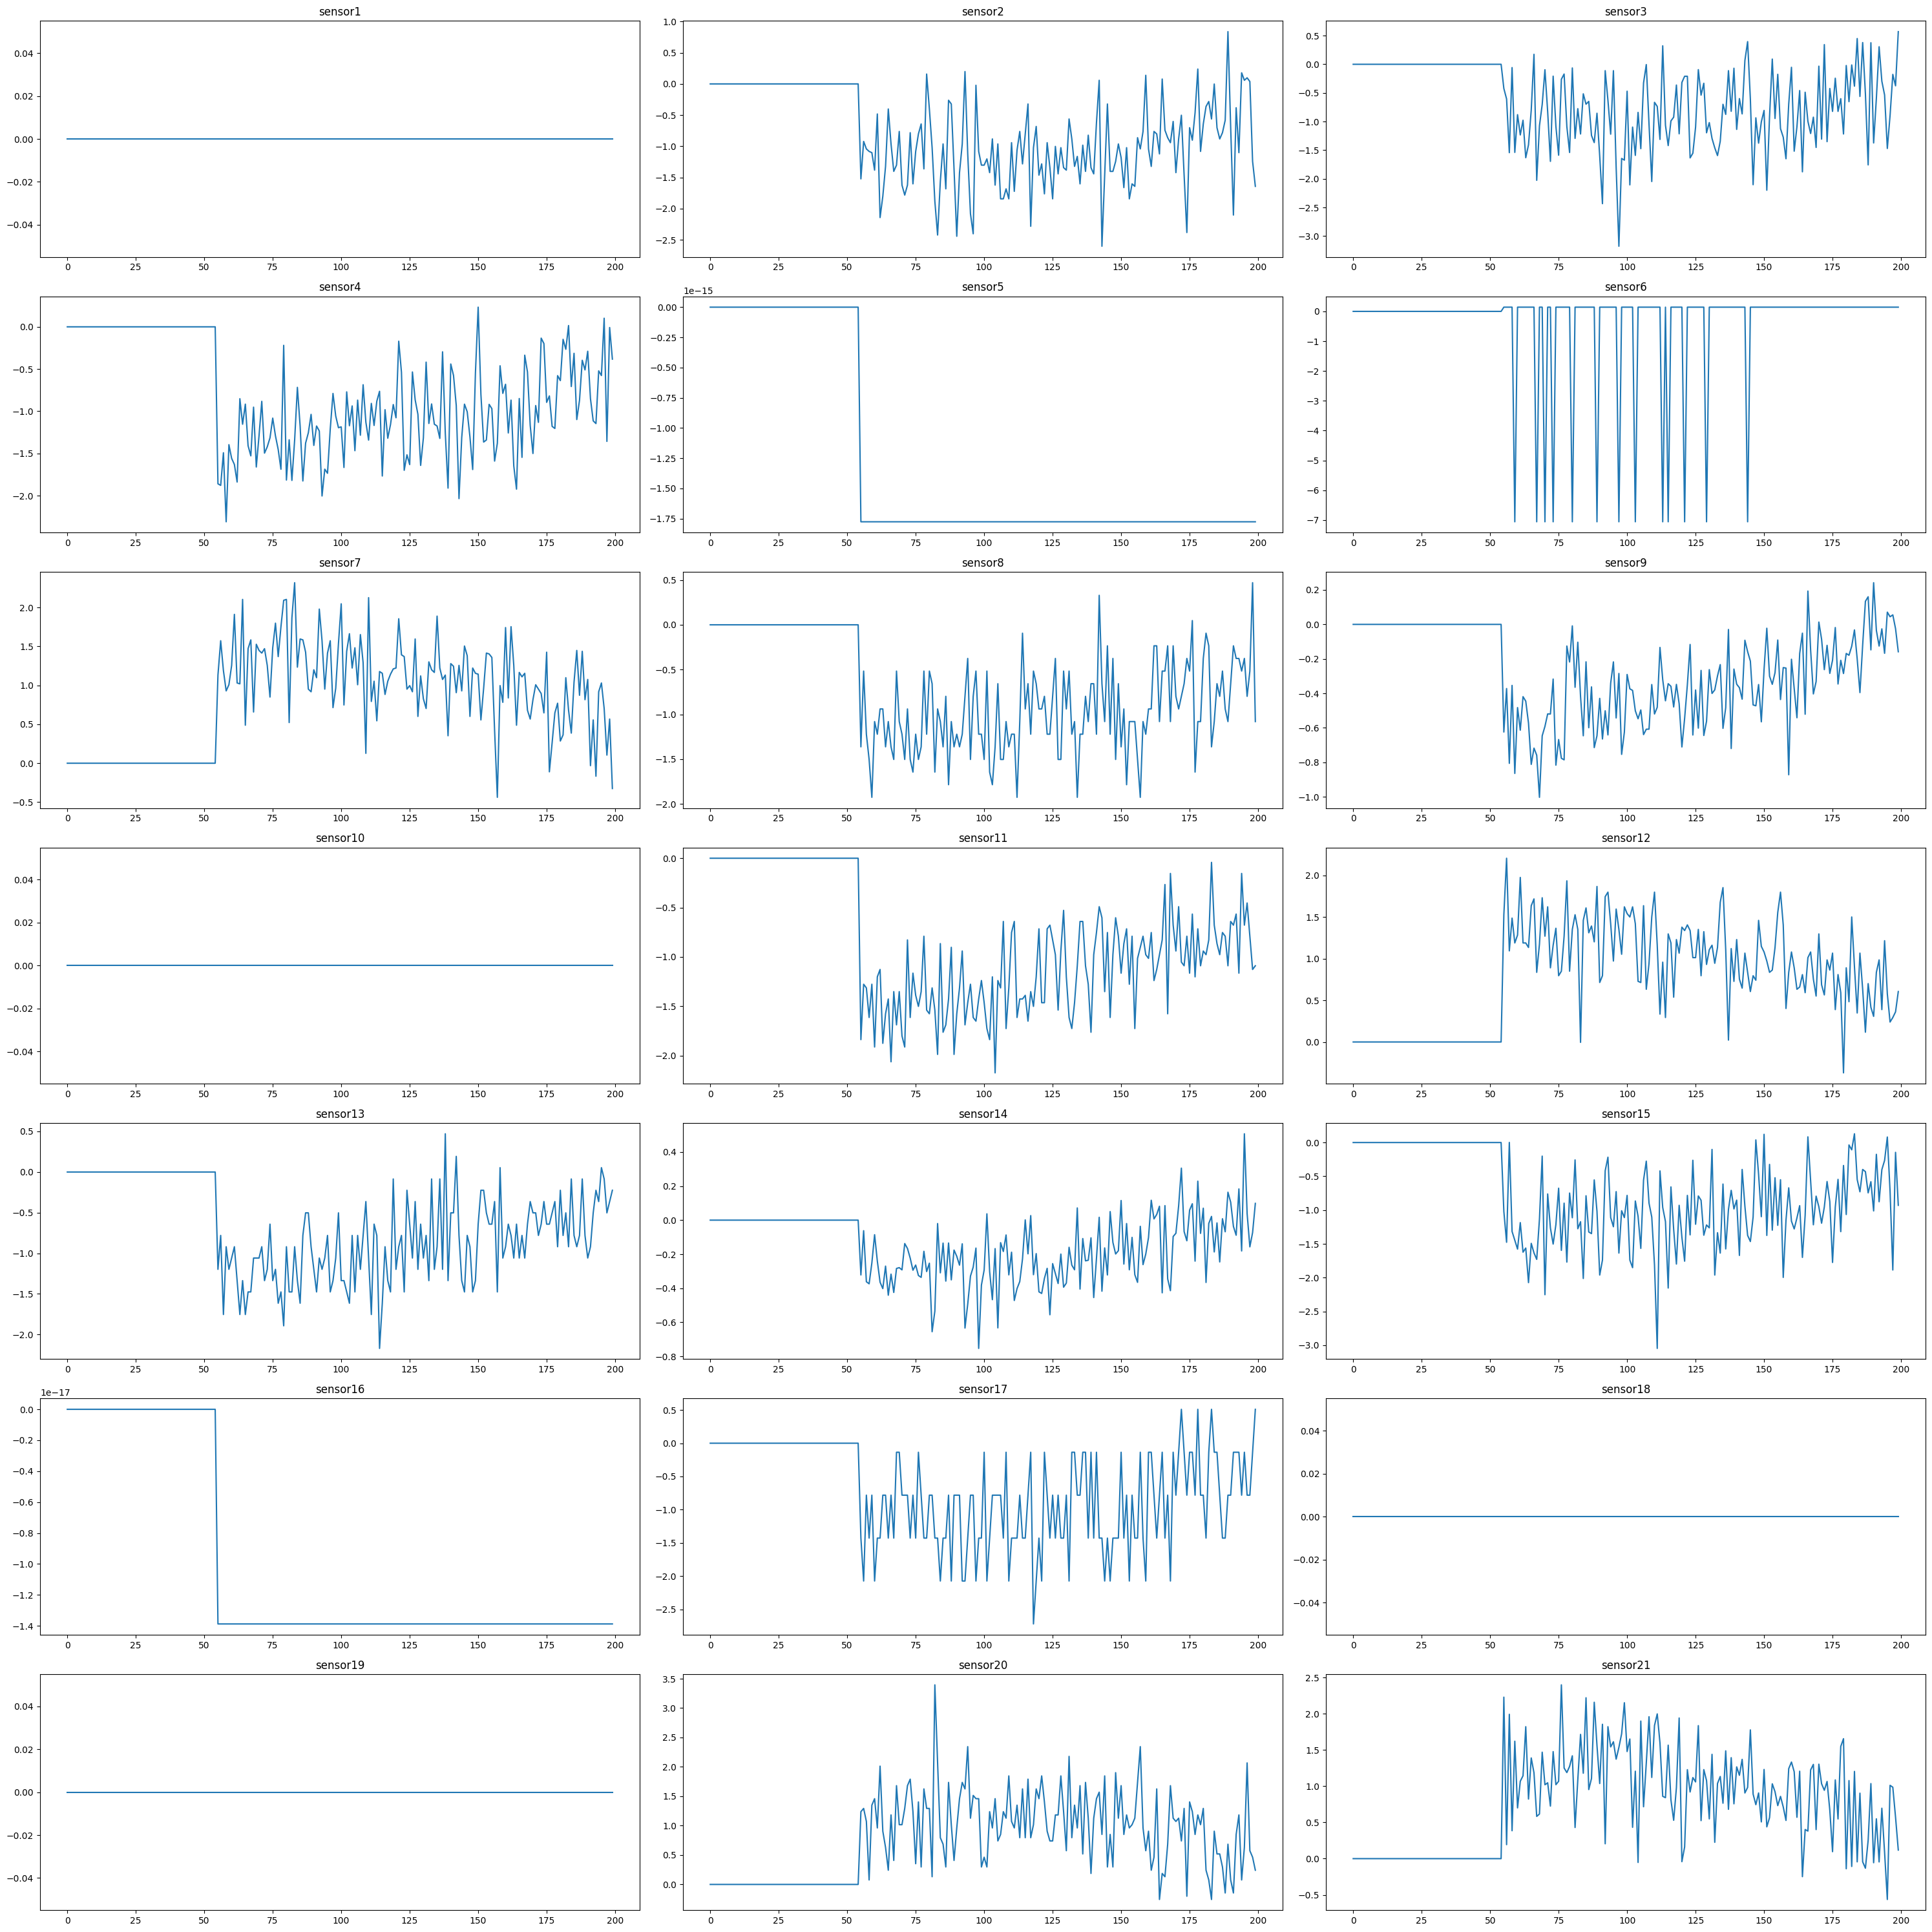

In [33]:
plotDataForIndex(padded_train, 450)

In [34]:
#Select sensors for the model
selected_sensors = [2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21]
selected_sensors_indices = [x - 1 for x in selected_sensors]

In [35]:
X_train = padded_train[:, :, 5:26][:, :, selected_sensors_indices]
X_test = padded_test[:, :, 5:26][:, :, selected_sensors_indices]

In [36]:
y_train = np.array(train_ruls).reshape(-1, 1)
y_test = np.array(test_ruls).reshape(-1,1)

In [37]:
numOfSensors = len(X_train[0][0])

In [38]:
import codecs, json
def exportNPArrayToJSON(a, fileName):
    b = a.tolist()
    json.dump(b, codecs.open(fileName, 'w', encoding='utf-8'))

In [39]:
test_FD = 'test_FD00' + str(setNumber) + ".json"
train_FD = 'train_FD00' + str(setNumber) + ".json"
test_RUL_FD = 'test_RUL_FD00' + str(setNumber) + ".json"
train_RUL_FD = 'train_RUL_FD00' + str(setNumber) + ".json"
exportNPArrayToJSON(X_test, test_FD)
exportNPArrayToJSON(y_test, test_RUL_FD)

In [40]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten

In [41]:
from tensorflow.keras.layers import Conv1D

In [42]:
import numpy as np
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Bidirectional
from sklearn.metrics import mean_squared_error

def createBiLSTMModel(input_shape, conv_layers, lstm_layers, dense_layers,
                      filters_list, kernel_size_list, strides_list,
                      pool_size_list, pool_strides_list,
                      lstm_units, dense_units, output_units, dropout_rate):
    model = Sequential()

    for i in range(conv_layers):
        filters = filters_list[i]
        kernel_size = kernel_size_list[i]
        strides = strides_list[i]
        pool_size = pool_size_list[i]
        pool_strides = pool_strides_list[i]

        if i == 0:
            model.add(Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', input_shape=input_shape, name='cv' + str(i)))
        else:
            model.add(Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', name='cv' + str(i)))
        model.add(BatchNormalization(axis=-1, name='bn' + str(i)))
        model.add(MaxPooling1D(pool_size=pool_size, strides=pool_strides, padding='same', name='mp' + str(i)))

    for i in range(lstm_layers):
        model.add(Bidirectional(LSTM(lstm_units, return_sequences=(i < lstm_layers - 1), name='lstm' + str(i))))
        model.add(Dropout(dropout_rate, name='lstm_do' + str(i)))

    for i in range(dense_layers):
        model.add(Dense(dense_units, activation='relu', name='dense' + str(i)))
        model.add(Dropout(dropout_rate, name='do' + str(i)))

    model.add(Dense(output_units))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


In [47]:
import random
import numpy as np

def PSO_optimization(X_train, y_train, population_size, generations, input_shape):
    hyperparameters = {
        'conv_layers': list(range(1, 4)),
        'lstm_layers': list(range(1, 3)),
        'dense_layers': list(range(1, 3)),
        'filters_list': [[random.choice(range(16, 33)), random.choice(range(32, 65)), random.choice(range(64, 129))]],
        'kernel_size_list': [[random.choice(range(2, 5)), random.choice(range(2, 5)), random.choice(range(2, 5))]],
        'strides_list': [[random.choice(range(1, 3)), random.choice(range(1, 3)), random.choice(range(1, 3))]],
        'pool_size_list': [[random.choice(range(2, 5)), random.choice(range(2, 5)), random.choice(range(2, 5))]],
        'pool_strides_list': [[random.choice(range(1, 3)), random.choice(range(1, 3)), random.choice(range(1, 3))]],
        'lstm_units': list(range(32, 129)),
        'dense_units': list(range(32, 129)),
        'output_units': [1],
        'dropout_rate': list(np.linspace(0.1, 0.3))  # converted to list
    }

    def create_particle():
        particle = {param: random.choice(values) for param, values in hyperparameters.items()}
        particle['velocity'] = {param: random.uniform(-1, 1) for param in hyperparameters.keys()}
        particle['personal_best'] = particle.copy()
        particle['personal_best_fitness'] = float('inf')
        return particle

    def update_particle(particle, global_best_particle, w, c1, c2):
        for param in hyperparameters.keys():
            r1, r2 = random.random(), random.random()

            if isinstance(particle[param], list):
                cognitive_velocity = c1 * r1 * np.array([(bp - p) for bp, p in zip(particle['personal_best'][param], particle[param])])
                social_velocity = c2 * r2 * np.array([(gbp - p) for gbp, p in zip(global_best_particle[param], particle[param])])
                particle['velocity'][param] = w * np.array(particle['velocity'][param]) + cognitive_velocity + social_velocity
                particle[param] = [x + v for x, v in zip(particle[param], particle['velocity'][param])]
            else:
                cognitive_velocity = c1 * r1 * (particle['personal_best'][param] - particle[param])
                social_velocity = c2 * r2 * (global_best_particle[param] - particle[param])
                particle['velocity'][param] = w * particle['velocity'][param] + cognitive_velocity + social_velocity
                particle[param] += particle['velocity'][param]

            # Clamp the values to stay within the hyperparameter ranges
            if param in ['conv_layers', 'lstm_layers', 'dense_layers', 'lstm_units', 'dense_units', 'output_units']:
                particle[param] = int(round(particle[param]))
                particle[param] = max(hyperparameters[param][0], min(particle[param], hyperparameters[param][-1]))
            elif isinstance(particle[param], list):
                for i in range(len(particle[param])):
                    particle[param][i] = max(hyperparameters[param][0][i], min(particle[param][i], hyperparameters[param][-1][i]))
            else:
                particle[param] = max(hyperparameters[param][0], min(particle[param], hyperparameters[param][-1]))

    population = [create_particle() for _ in range(population_size)]
    global_best_particle = None
    global_best_fitness = float('inf')

    for _ in range(generations):
        for particle in population:
            model = createBiLSTMModel(input_shape, **{param: particle[param] for param in hyperparameters.keys()})
            model.fit(X_train, y_train, batch_size=32, epochs=4, verbose=0)
            fitness = model.evaluate(X_train, y_train, verbose=0)[0]
            particle['fitness'] = fitness

            if fitness < particle['personal_best_fitness']:
                particle['personal_best_fitness'] = fitness
                particle['personal_best'] = particle.copy()

            if fitness < global_best_fitness:
                global_best_fitness = fitness
                global_best_particle = particle.copy()

        for particle in population:
            update_particle(particle, global_best_particle, w=0.5, c1=1.5, c2=1.5)

    return global_best_particle

# Example usage
input_shape = (maxlen, len(selected_sensors_indices))
best_individual = PSO_optimization(X_train, y_train, population_size=10, generations=5, input_shape=input_shape)
print("Best individual:", best_individual)


Best individual: {'conv_layers': 3, 'lstm_layers': 2, 'dense_layers': 2, 'filters_list': [27, 38, 78], 'kernel_size_list': [4, 2, 2], 'strides_list': [2, 1, 1], 'pool_size_list': [2, 4, 4], 'pool_strides_list': [1, 1, 2], 'lstm_units': 60, 'dense_units': 91, 'output_units': 1, 'dropout_rate': 0.3, 'velocity': {'conv_layers': -0.006952498020869252, 'lstm_layers': -0.018734128704342573, 'dense_layers': 0.004076628823656059, 'filters_list': array([0.01549014, 0.01549014, 0.01549014]), 'kernel_size_list': array([-0.00180375, -0.00180375, -0.00180375]), 'strides_list': array([0.00666463, 0.00666463, 0.00666463]), 'pool_size_list': array([0.01197067, 0.01197067, 0.01197067]), 'pool_strides_list': array([0.02406751, 0.02406751, 0.02406751]), 'lstm_units': 3.8541460156145915, 'dense_units': -4.706974351742545, 'output_units': -0.013308660759993103, 'dropout_rate': 0.011978920226552501}, 'personal_best': {'conv_layers': 3, 'lstm_layers': 2, 'dense_layers': 2, 'filters_list': [27, 38, 78], 'kern

In [1]:
best_params = PSO_optimization(X_train, y_train, population_size=10, generations=5, input_shape=(maxlen, numOfSensors))

NameError: name 'PSO_optimization' is not defined

In [ ]:
best_filters = best_individual['filters_list']
best_kernel_size = best_individual['kernel_size_list']
best_strides = best_individual['strides_list']
best_pool_size = best_individual['pool_size_list']
best_pool_strides = best_individual['pool_strides_list']
best_lstm_units = best_individual['lstm_units']
best_dense_units = best_individual['dense_units']
best_dropout_rate = best_individual['dropout_rate']

In [ ]:
best_model = createBiLSTMModel(input_shape,
                              conv_layers=best_individual['conv_layers'],
                              lstm_layers=best_individual['lstm_layers'],
                              dense_layers=best_individual['dense_layers'],
                              filters_list=best_filters,
                              kernel_size_list=best_kernel_size,
                              strides_list=best_strides,
                              pool_size_list=best_pool_size,
                              pool_strides_list=best_pool_strides,
                              lstm_units=best_lstm_units,
                              dense_units=best_dense_units,
                              output_units=1,
                              dropout_rate=best_dropout_rate)

# Train the best model
best_model.fit(X_train, y_train, batch_size=32, epochs=4, verbose=0)

In [ ]:
test_loss, test_mae = best_model.evaluate(X_test, y_test)
test_predictions = best_model.predict(X_test)

4/4 [==============================] - 2s 56ms/step


In [ ]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, test_predictions, squared=False)

print("Test MAE:", test_mae)
print("Test RMSE:", rmse)

Test MAE: 15.801854133605957
Test RMSE: 18.7066892406204
